## Repeated Copy

In this task, a sequence of bit vectors is provided to the model. The input sequence starts with a reserved start vector, then some random binary bit vectors, followed by a reserved count vector, providing the number of intended repetition in a reserved channel. The model is expected to start reproducing the exact input bit vectors for given number of repetitions immediately after observing the count vector.





In [1]:
from util import *
from dnc_lstm import DNC
from dnc_ff import DNCFF
from autograd import grad
from autograd.misc.optimizers import rmsprop, adam

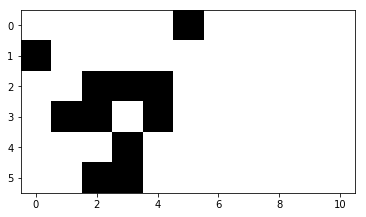

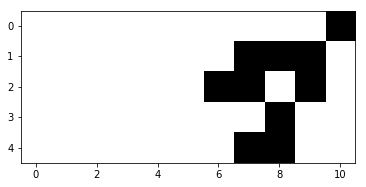

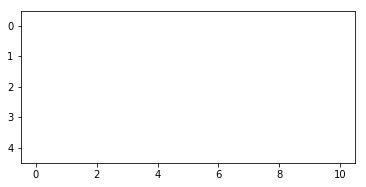

In [2]:
def repeat_copy(max_seq_len, seq_width, max_repeat=4):
    """
    Implements the repeated copy task
    max_seq_len - maximum length of the sequence
    seq_width - size of bit vector at each time step
    max_repeat - maximum number of repetitions
    """
    seq_len = 1 + np.random.randint(max_seq_len)
    repeat = 1 + np.random.randint(max_repeat)
    rand_tile = np.random.randint(2, size=(seq_len, seq_width))
    inputs = np.zeros((seq_len*(1+repeat)+3, seq_width+2))
    inputs[0,1] = 1
    inputs[seq_len+1,0] = repeat
    inputs[1:seq_len+1, 2:] = rand_tile
    targets = np.zeros((seq_len*(1+repeat)+3, seq_width+1))
    targets[-1,0] = 1
    targets[seq_len+2:-1, 1:] = np.vstack([rand_tile]*repeat)
    mask = np.ones_like(targets)
#     mask = np.zeros((seq_len*2+3, seq_width+1))
#     mask[seq_len+2:,:] = 1
    return inputs, targets, mask

inputs, targets, mask = repeat_copy(4, 4)
display(inputs.T)
display(targets.T)
display(mask.T)


Training DNC...
('Iteration', 0, 'Train loss:', 0.69069729177730632)
Test loss:  0.691287706614
Input


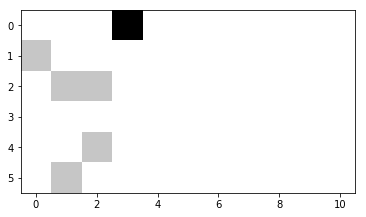

Target


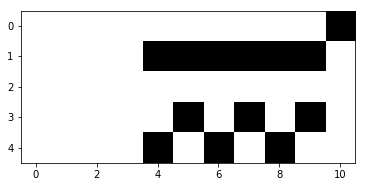

Predicted


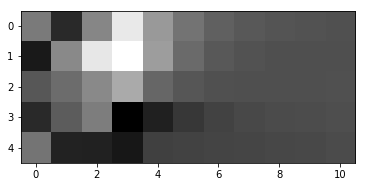

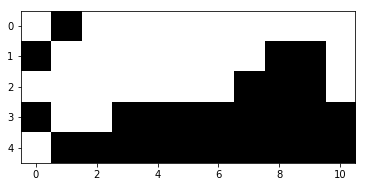

('Iteration', 1000, 'Train loss:', 0.42135382910983649)
Test loss:  0.376769325344
Input


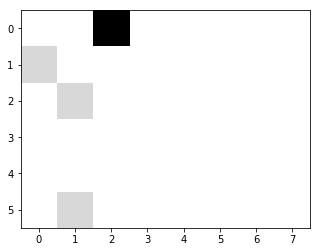

Target


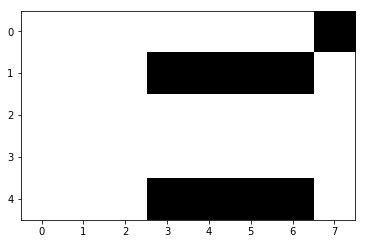

Predicted


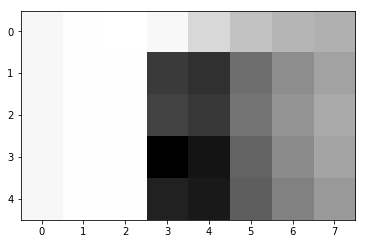

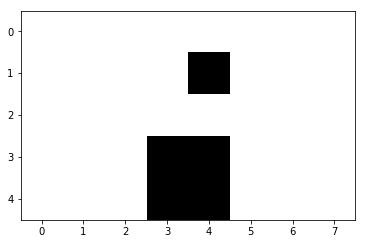

('Iteration', 2000, 'Train loss:', 0.35089708367102262)
Test loss:  0.413362477659
Input


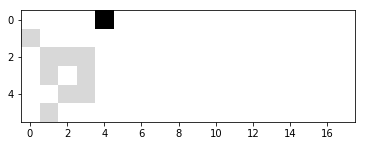

Target


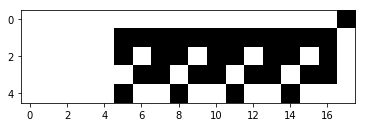

Predicted


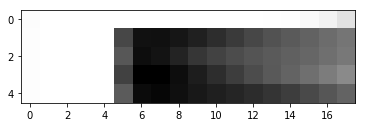

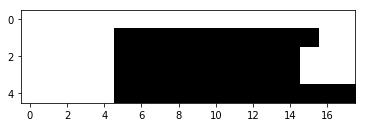

('Iteration', 3000, 'Train loss:', 0.20673547261609432)
Test loss:  0.214357775786
Input


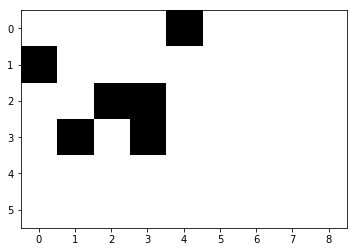

Target


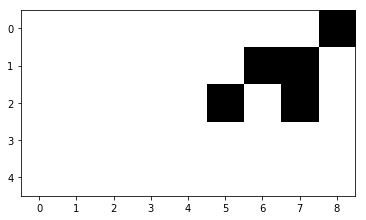

Predicted


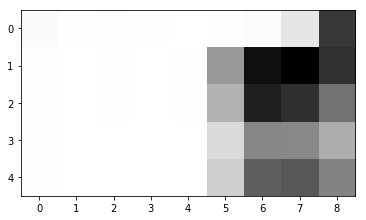

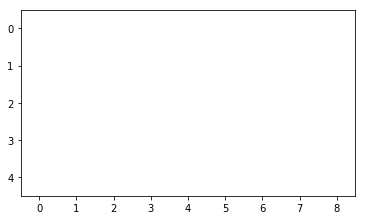

('Iteration', 4000, 'Train loss:', 0.3071864907486907)
Test loss:  0.11830686185
Input


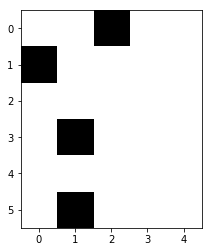

Target


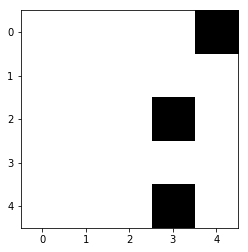

Predicted


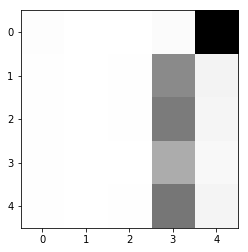

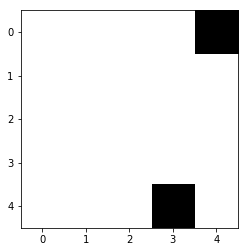

('Iteration', 5000, 'Train loss:', 0.13852566725707269)
Test loss:  0.0609098338176
Input


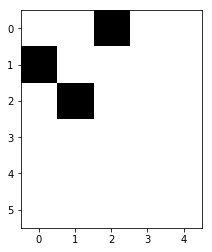

Target


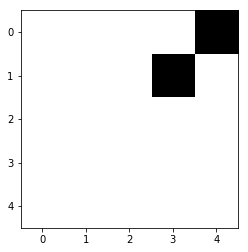

Predicted


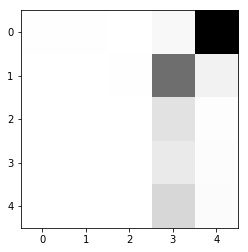

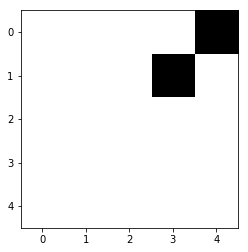

('Iteration', 6000, 'Train loss:', 0.2984570900420554)
Test loss:  0.070484695485
Input


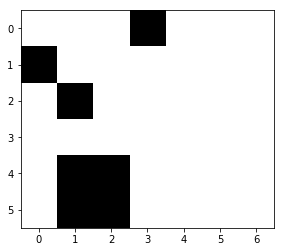

Target


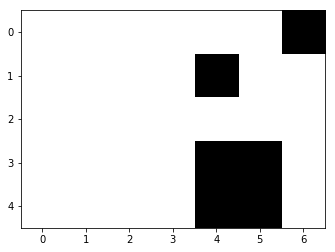

Predicted


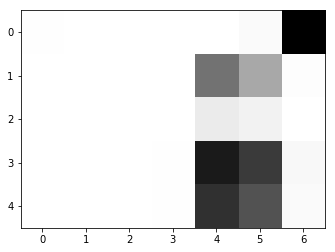

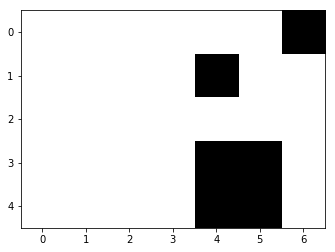

('Iteration', 7000, 'Train loss:', 0.051364450020902418)
Test loss:  0.0446099919806
Input


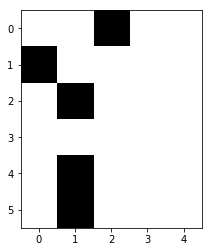

Target


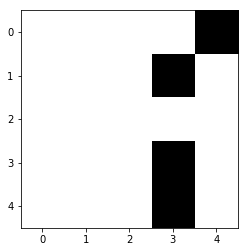

Predicted


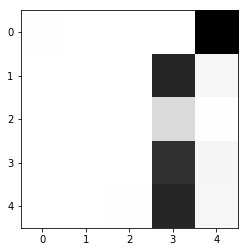

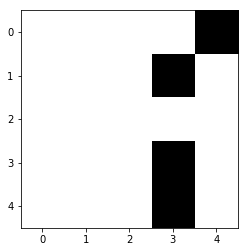

('Iteration', 8000, 'Train loss:', 0.33925223308474256)
Test loss:  0.11073959259
Input


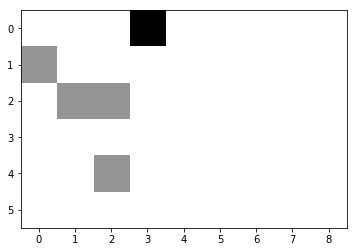

Target


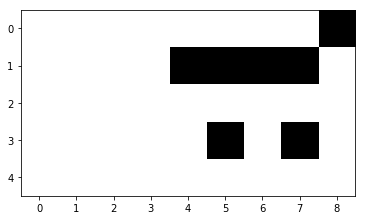

Predicted


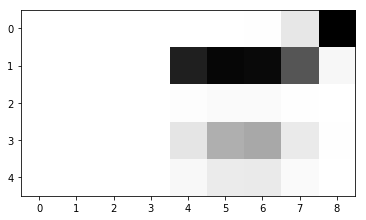

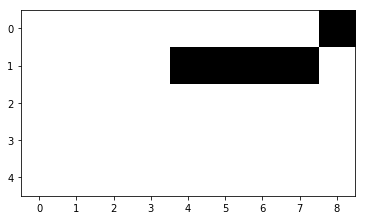

('Iteration', 9000, 'Train loss:', 0.15361438223926691)
Test loss:  0.0267598918007
Input


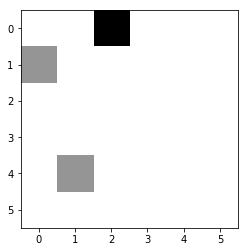

Target


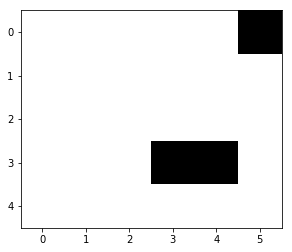

Predicted


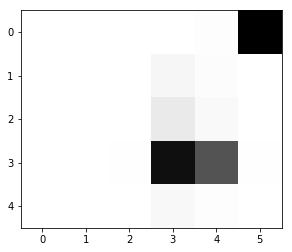

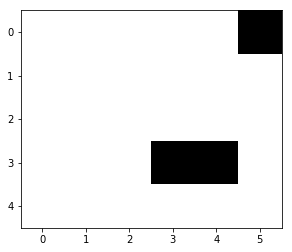

('Iteration', 10000, 'Train loss:', 0.34846297752920624)
Test loss:  0.0468774649595
Input


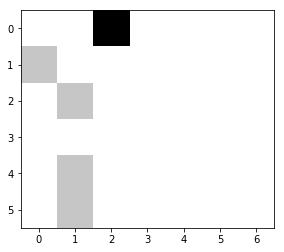

Target


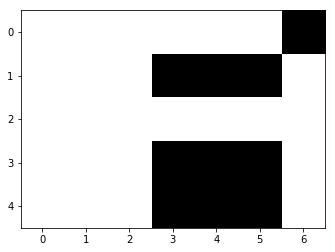

Predicted


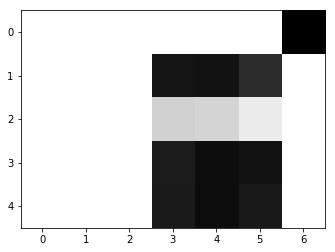

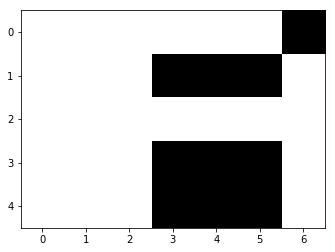

('Iteration', 11000, 'Train loss:', 0.19425164285097268)
Test loss:  0.300067040738
Input


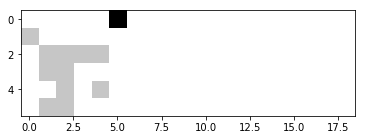

Target


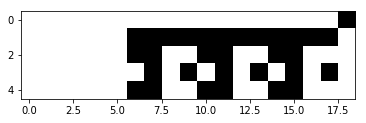

Predicted


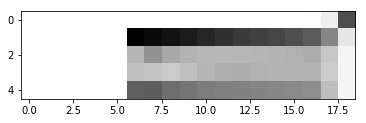

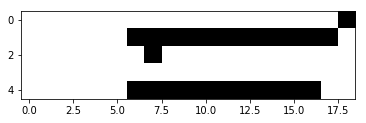

('Iteration', 12000, 'Train loss:', 0.10507062294736944)
Test loss:  0.0311865368791
Input


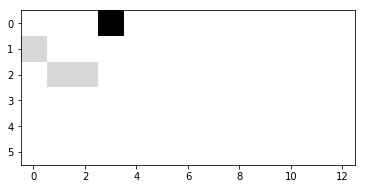

Target


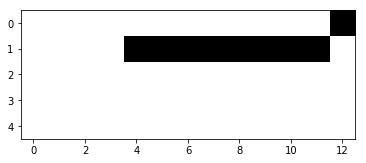

Predicted


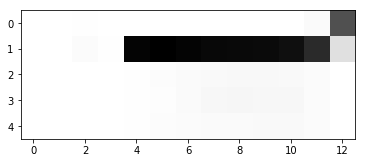

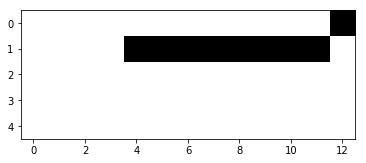

('Iteration', 13000, 'Train loss:', 0.072193963910669817)
Test loss:  0.0113999080376
Input


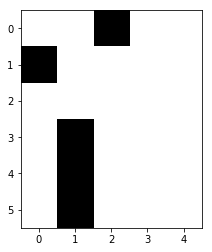

Target


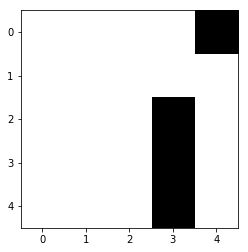

Predicted


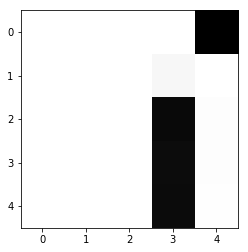

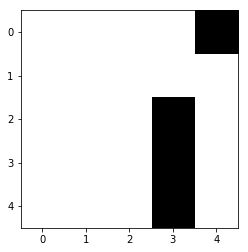

('Iteration', 14000, 'Train loss:', 0.18272597722777895)
Test loss:  0.00995547547528
Input


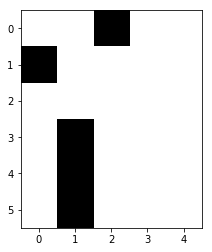

Target


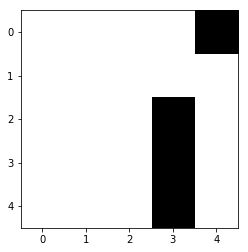

Predicted


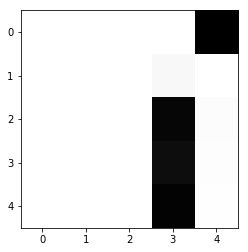

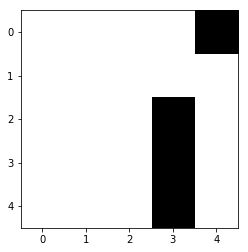

('Iteration', 15000, 'Train loss:', 0.25290543009186828)
Test loss:  0.172142493846
Input


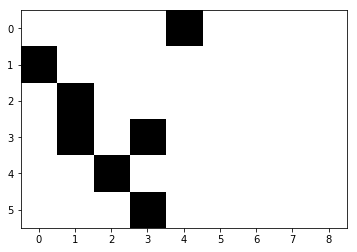

Target


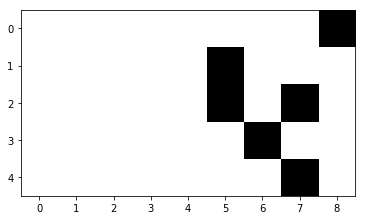

Predicted


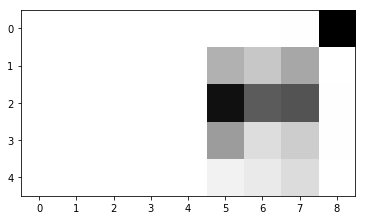

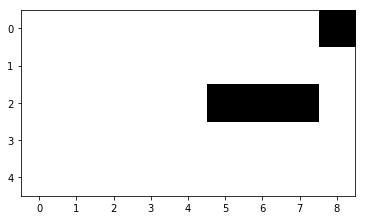

('Iteration', 16000, 'Train loss:', 0.15680150278806673)
Test loss:  0.250812975122
Input


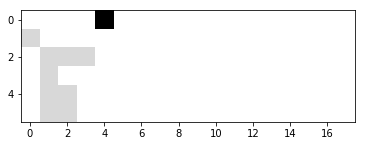

Target


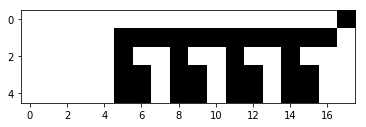

Predicted


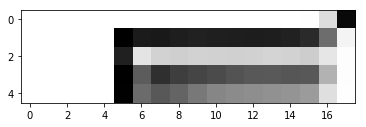

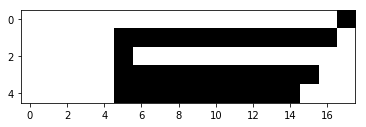

('Iteration', 17000, 'Train loss:', 0.23364056644403755)
Test loss:  0.161302249646
Input


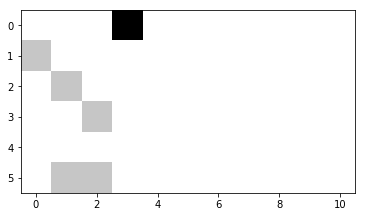

Target


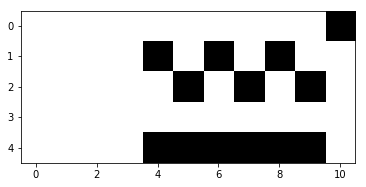

Predicted


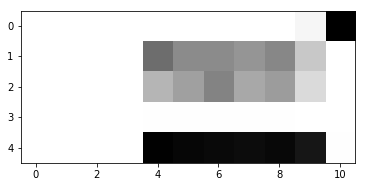

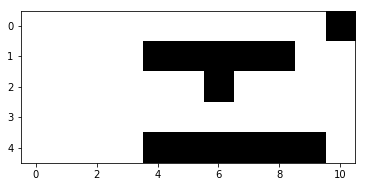

('Iteration', 18000, 'Train loss:', 0.0092984907935373656)
Test loss:  0.0373988685667
Input


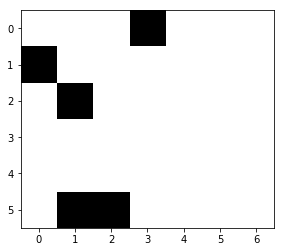

Target


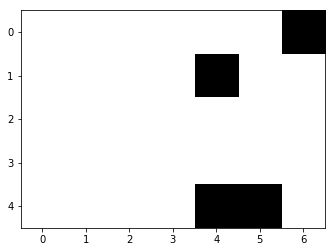

Predicted


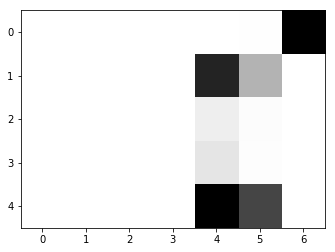

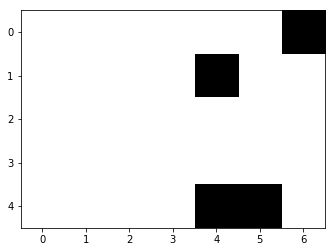

('Iteration', 19000, 'Train loss:', 0.18024503354840068)
Test loss:  0.00620429948137
Input


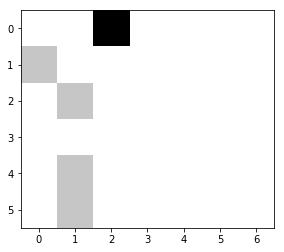

Target


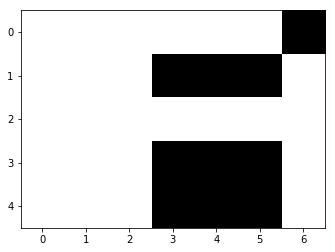

Predicted


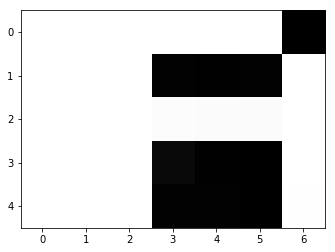

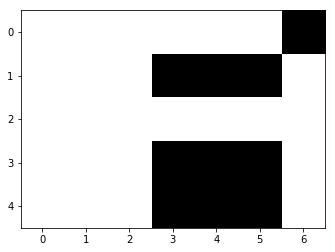

('Iteration', 20000, 'Train loss:', 0.32747222865419112)
Test loss:  0.242302064846
Input


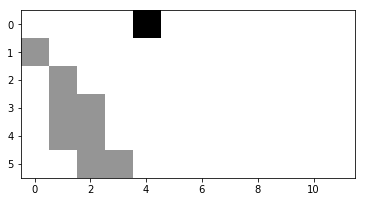

Target


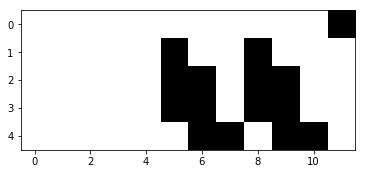

Predicted


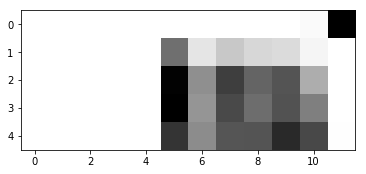

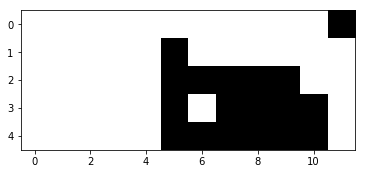

('Iteration', 21000, 'Train loss:', 0.019784429553275307)
Test loss:  0.00326733663121
Input


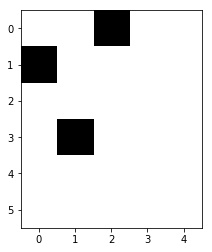

Target


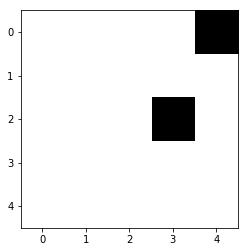

Predicted


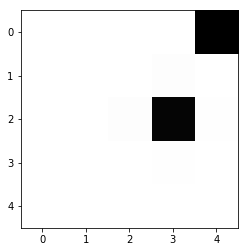

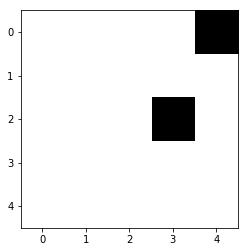

('Iteration', 22000, 'Train loss:', 0.31762755340452753)
Test loss:  0.300636362269
Input


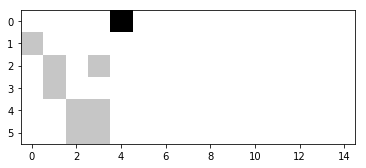

Target


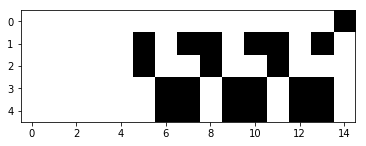

Predicted


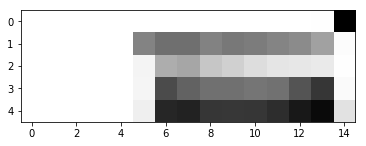

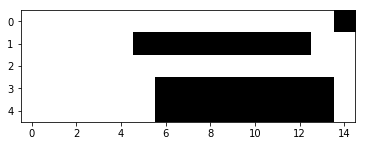

('Iteration', 23000, 'Train loss:', 0.0053205617713946189)
Test loss:  0.00528676191495
Input


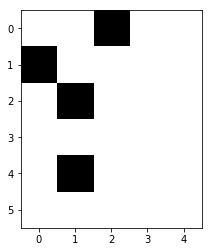

Target


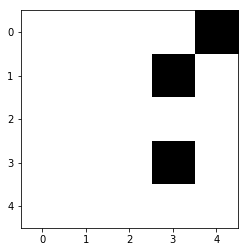

Predicted


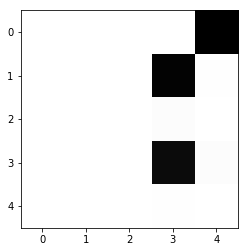

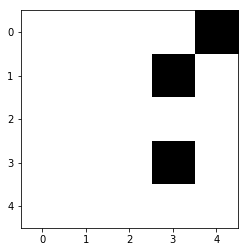

('Iteration', 24000, 'Train loss:', 0.26244959257778394)
Test loss:  0.178369993108
Input


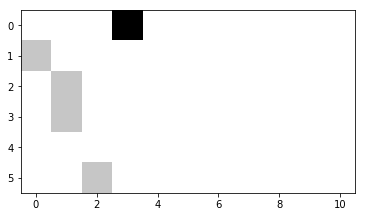

Target


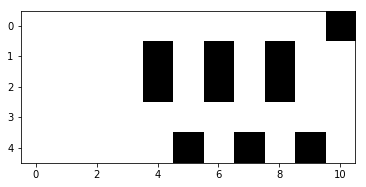

Predicted


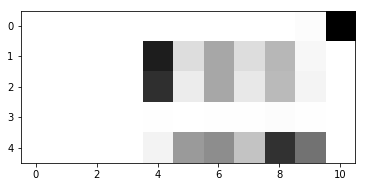

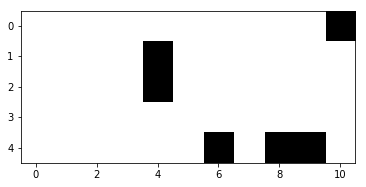

('Iteration', 25000, 'Train loss:', 0.0048121823372443183)
Test loss:  0.24229230124
Input


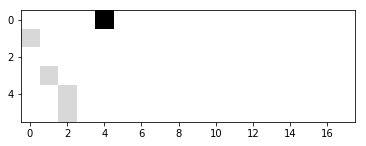

Target


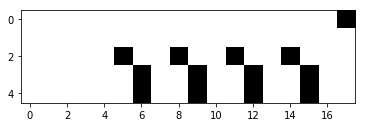

Predicted


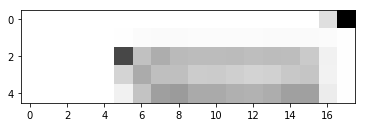

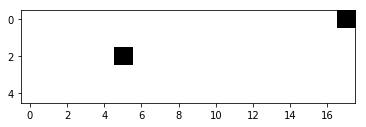

('Iteration', 26000, 'Train loss:', 0.11421883183826073)
Test loss:  0.267179691638
Input


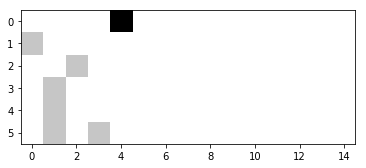

Target


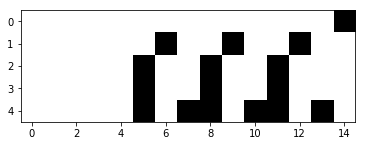

Predicted


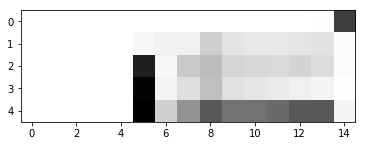

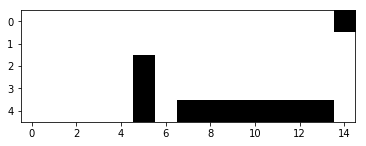

('Iteration', 27000, 'Train loss:', 0.14408690310197289)
Test loss:  0.202281962733
Input


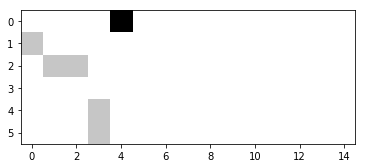

Target


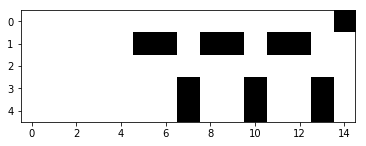

Predicted


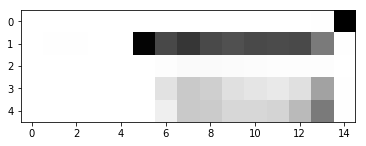

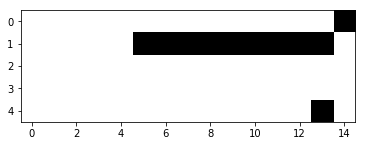

('Iteration', 28000, 'Train loss:', 0.01045454019808004)
Test loss:  0.0425885210581
Input


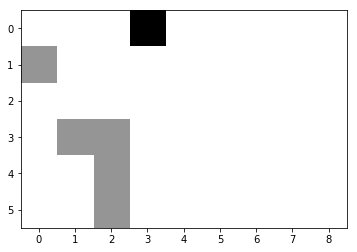

Target


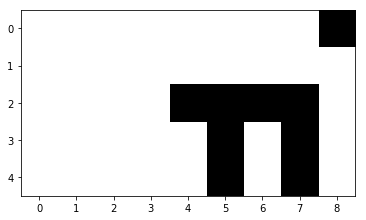

Predicted


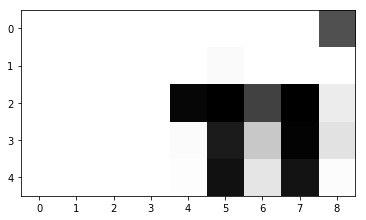

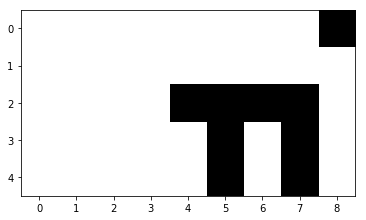

('Iteration', 29000, 'Train loss:', 0.35215517853498879)
Test loss:  0.0629373692045
Input


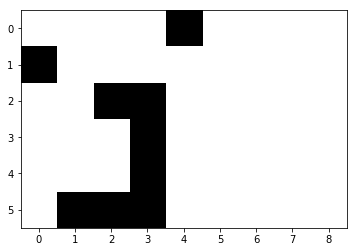

Target


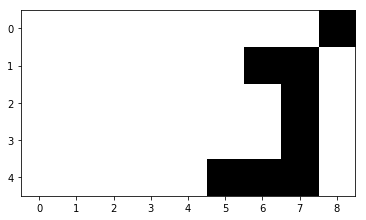

Predicted


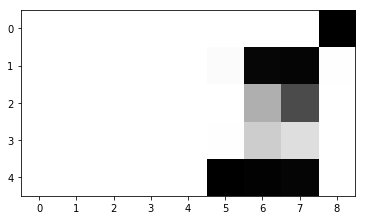

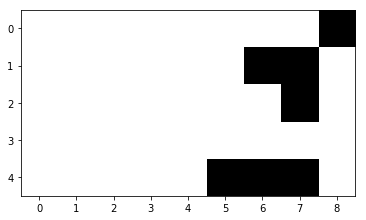

('Iteration', 30000, 'Train loss:', 0.14245566961905895)
Test loss:  0.300947578759
Input


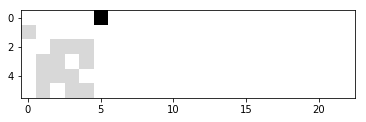

Target


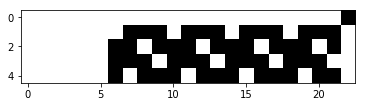

Predicted


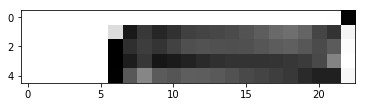

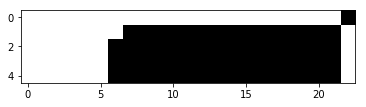

('Iteration', 31000, 'Train loss:', 0.055931571317706714)
Test loss:  0.134616803553
Input


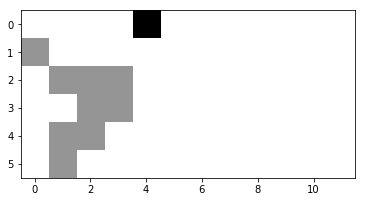

Target


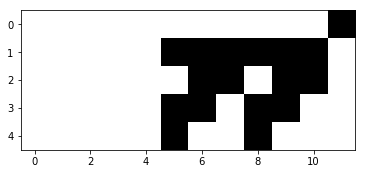

Predicted


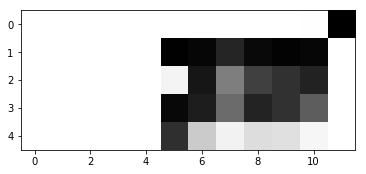

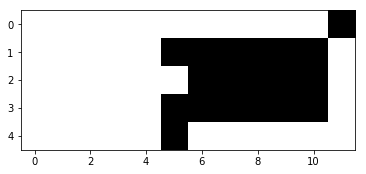

('Iteration', 32000, 'Train loss:', 0.058433327409944939)
Test loss:  0.0254349330845
Input


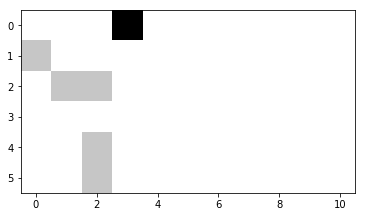

Target


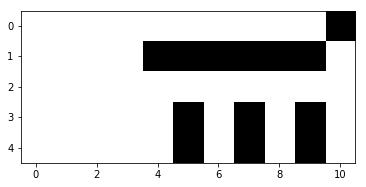

Predicted


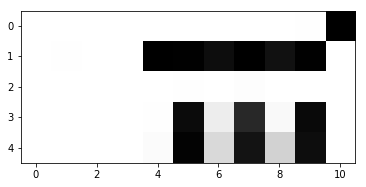

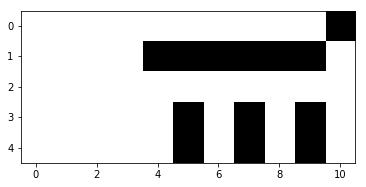

('Iteration', 33000, 'Train loss:', 0.0014256114375067286)
Test loss:  0.0739210571521
Input


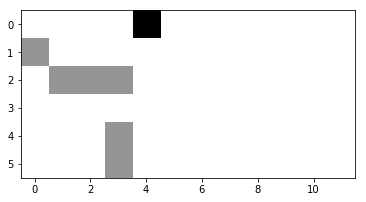

Target


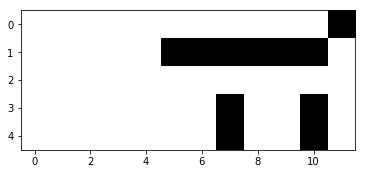

Predicted


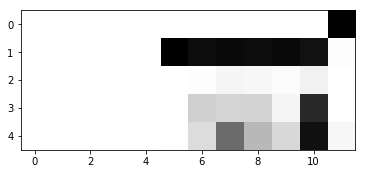

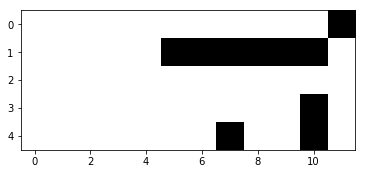

('Iteration', 34000, 'Train loss:', 0.14408032442462684)
Test loss:  0.0361135268178
Input


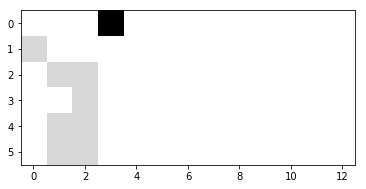

Target


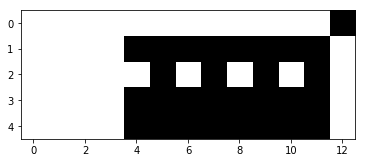

Predicted


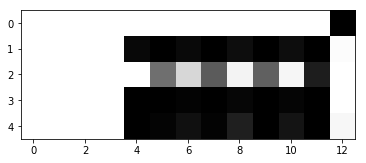

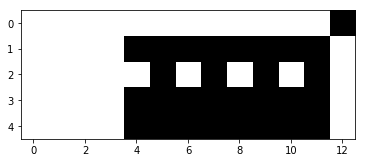

('Iteration', 35000, 'Train loss:', 0.29043137863617458)
Test loss:  0.139670092649
Input


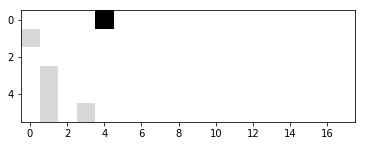

Target


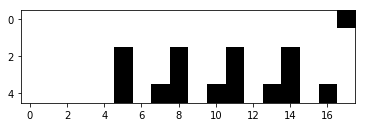

Predicted


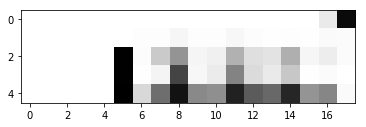

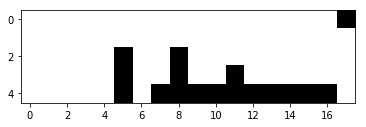

('Iteration', 36000, 'Train loss:', 0.081370996963598702)
Test loss:  0.214978187017
Input


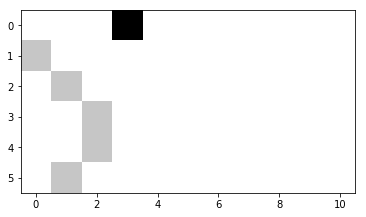

Target


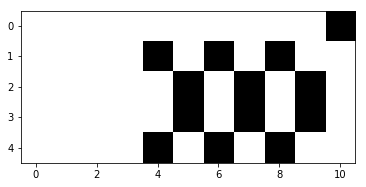

Predicted


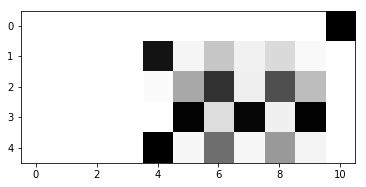

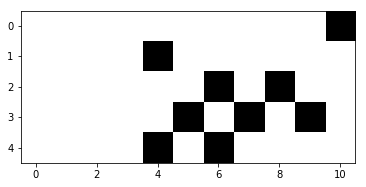

('Iteration', 37000, 'Train loss:', 0.0015813391378391522)
Test loss:  0.00747634116184
Input


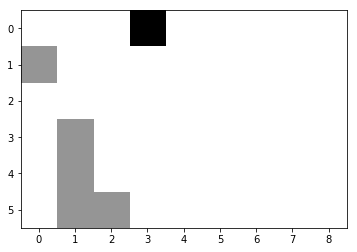

Target


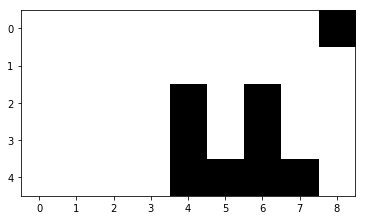

Predicted


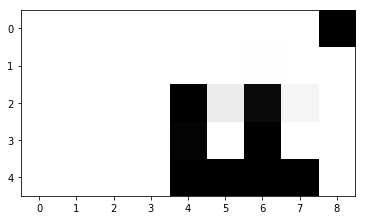

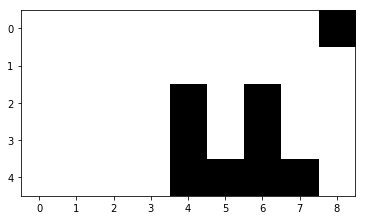

('Iteration', 38000, 'Train loss:', 0.26353123310781312)
Test loss:  0.00128846427039
Input


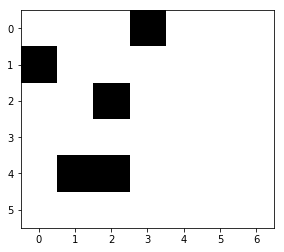

Target


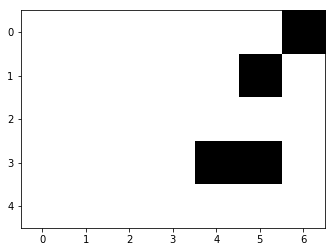

Predicted


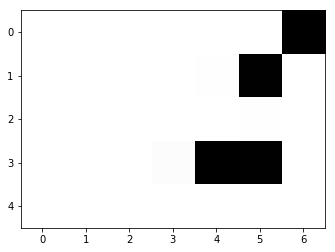

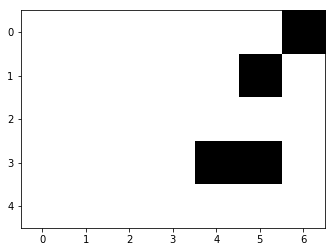

('Iteration', 39000, 'Train loss:', 0.23140586133344765)
Test loss:  0.00145916428865
Input


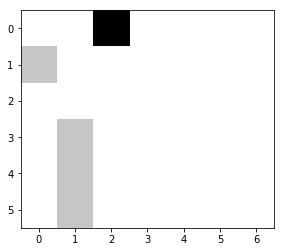

Target


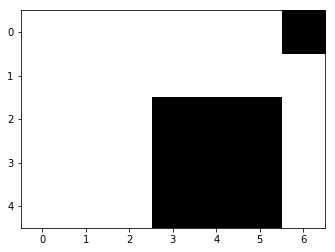

Predicted


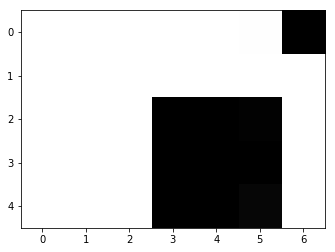

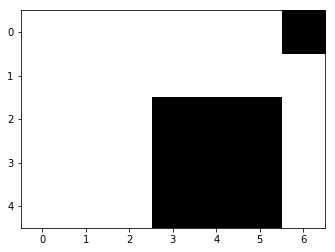

('Iteration', 40000, 'Train loss:', 0.087285256905843017)
Test loss:  0.0493957166275
Input


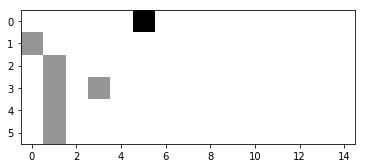

Target


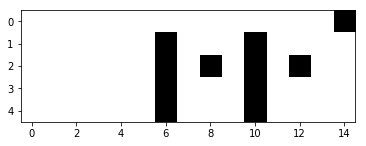

Predicted


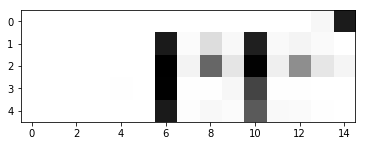

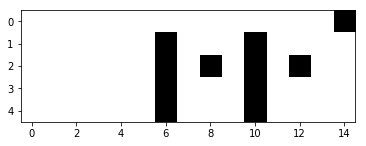

('Iteration', 41000, 'Train loss:', 0.0017607069478916017)
Test loss:  0.00281077984882
Input


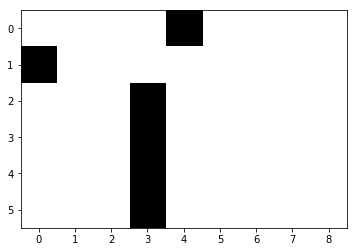

Target


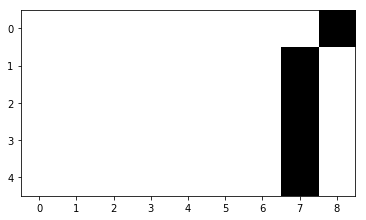

Predicted


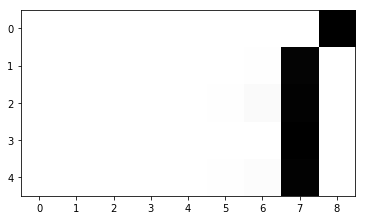

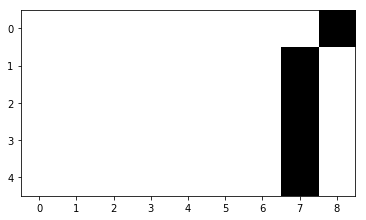

('Iteration', 42000, 'Train loss:', 0.00044729315843160874)
Test loss:  0.00370513002226
Input


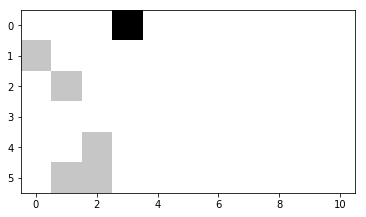

Target


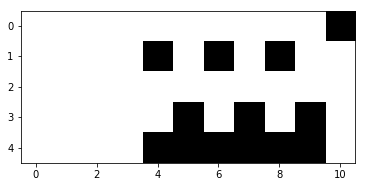

Predicted


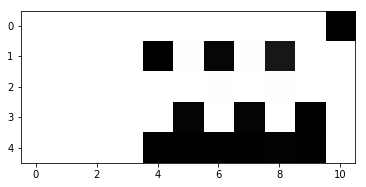

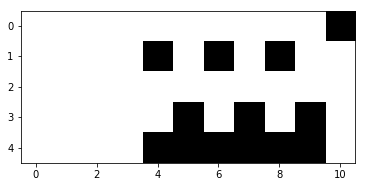

('Iteration', 43000, 'Train loss:', 0.039820095483341089)
Test loss:  0.000606301066797
Input


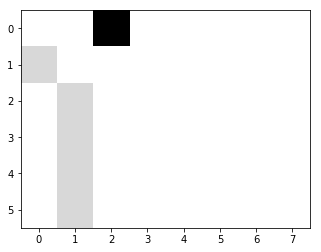

Target


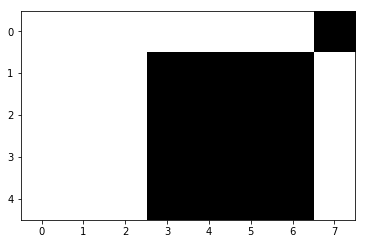

Predicted


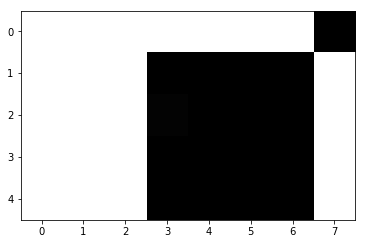

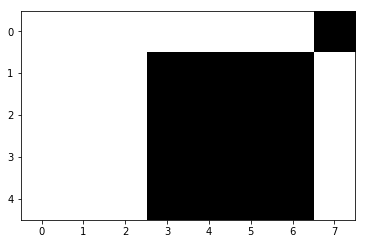

('Iteration', 44000, 'Train loss:', 0.037669873578218896)
Test loss:  0.00262684731325
Input


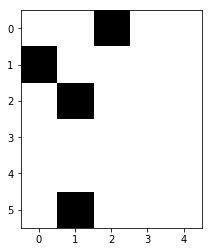

Target


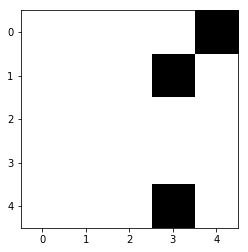

Predicted


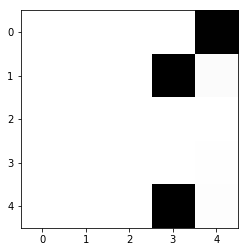

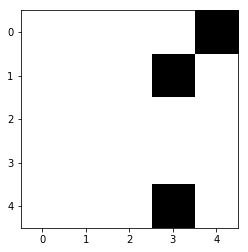

('Iteration', 45000, 'Train loss:', 0.0088328409304220326)
Test loss:  0.00354998824613
Input


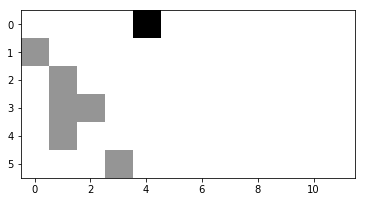

Target


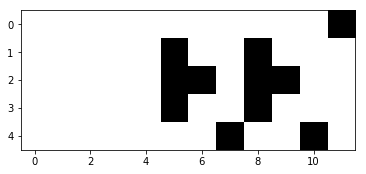

Predicted


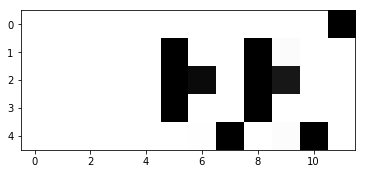

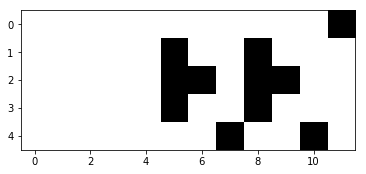

('Iteration', 46000, 'Train loss:', 0.00017406566708885027)
Test loss:  0.000689661361003
Input


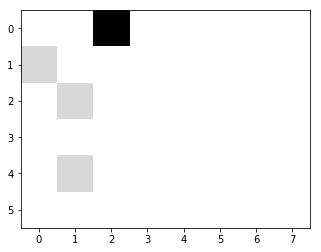

Target


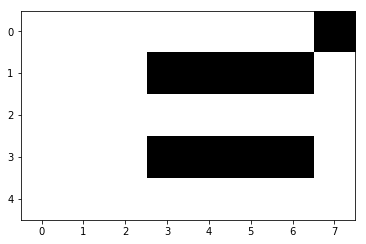

Predicted


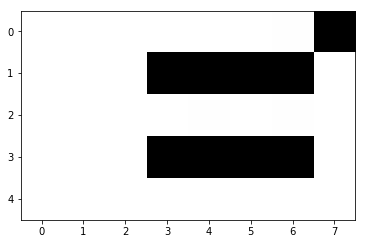

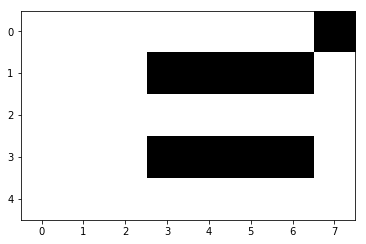

('Iteration', 47000, 'Train loss:', 0.0012662308965487405)
Test loss:  0.00033595135395
Input


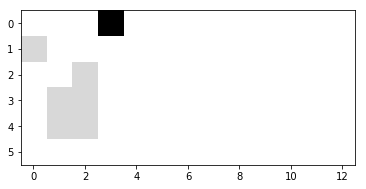

Target


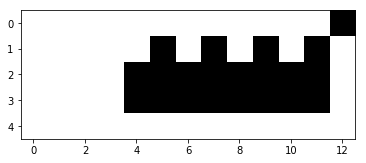

Predicted


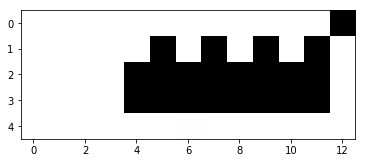

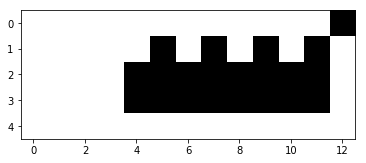

('Iteration', 48000, 'Train loss:', 0.00093119956331501482)
Test loss:  0.000324923348861
Input


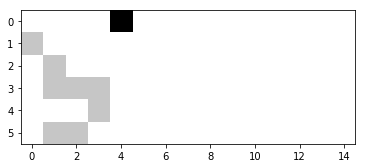

Target


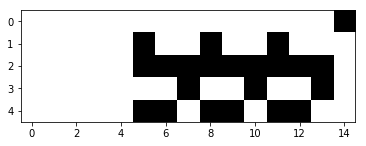

Predicted


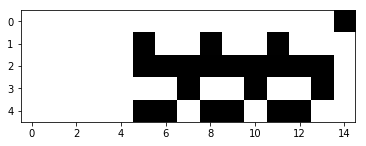

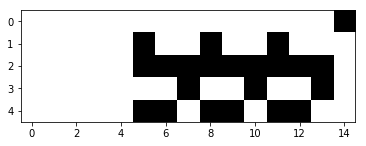

('Iteration', 49000, 'Train loss:', 0.00017282588844590605)
Test loss:  0.000194660470166
Input


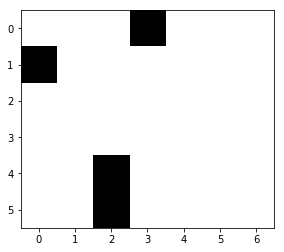

Target


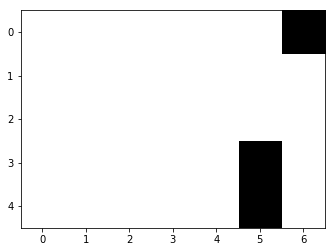

Predicted


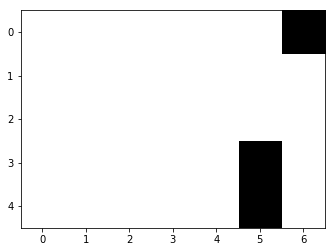

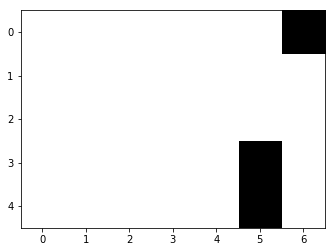

('Iteration', 50000, 'Train loss:', 0.00029953467523112986)
Test loss:  0.000312088732344
Input


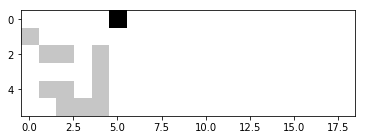

Target


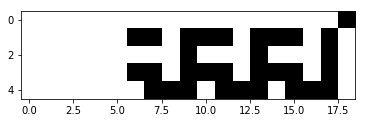

Predicted


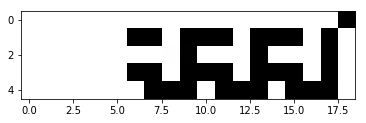

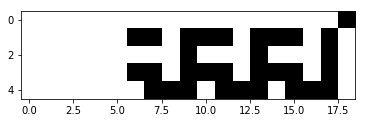

('Iteration', 51000, 'Train loss:', 0.00030659809807228445)
Test loss:  0.000105970578261
Input


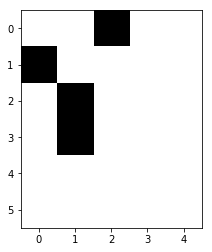

Target


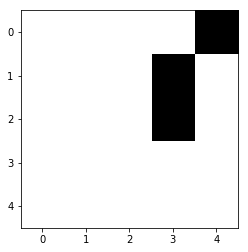

Predicted


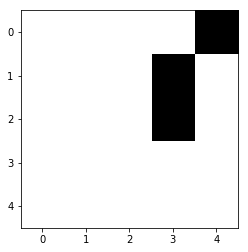

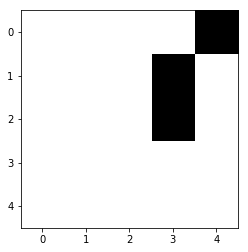

('Iteration', 52000, 'Train loss:', 0.0026552076472592685)
Test loss:  8.60072098336e-05
Input


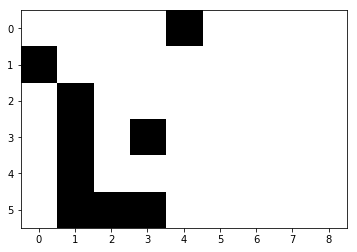

Target


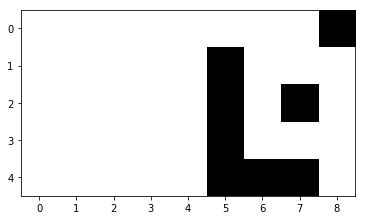

Predicted


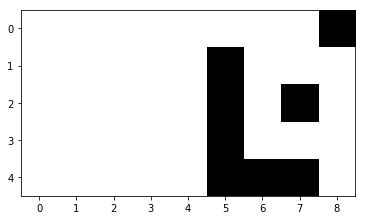

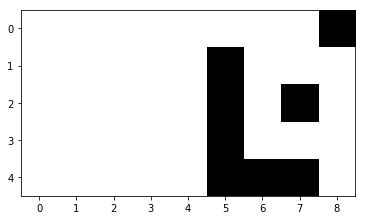

('Iteration', 53000, 'Train loss:', 4.0497982878906406e-05)
Test loss:  6.3699830814e-05
Input


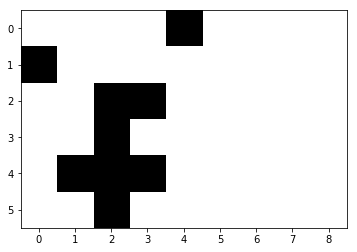

Target


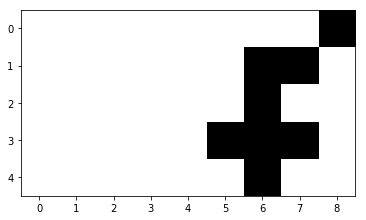

Predicted


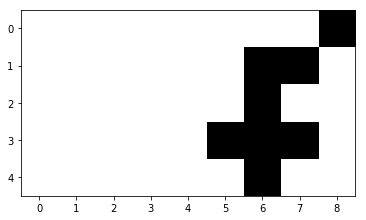

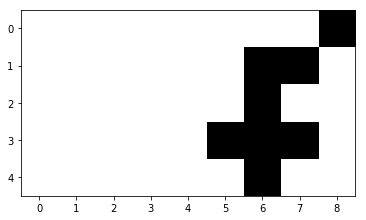

('Iteration', 54000, 'Train loss:', 7.2436552556273315e-05)
Test loss:  3.47037899032e-05
Input


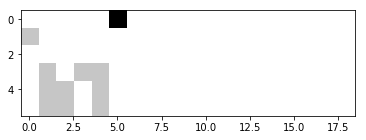

Target


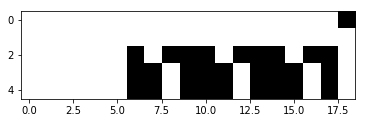

Predicted


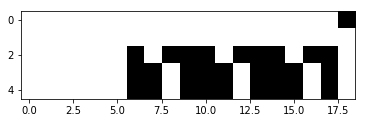

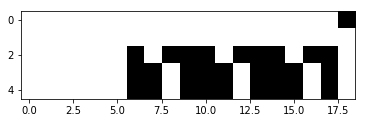

('Iteration', 55000, 'Train loss:', 1.0495545041696118e-05)
Test loss:  0.000229579767125
Input


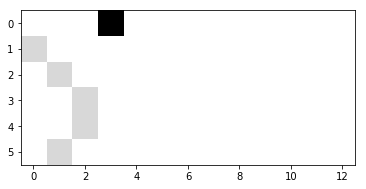

Target


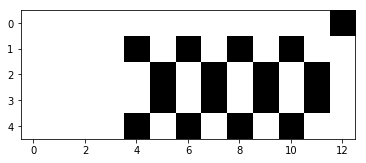

Predicted


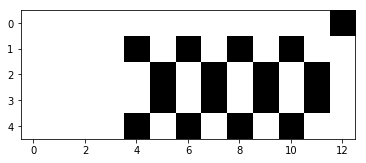

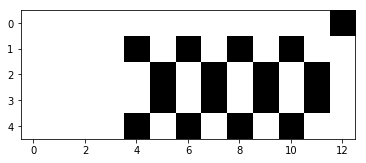

('Iteration', 56000, 'Train loss:', 4.3810890807900747e-05)
Test loss:  5.82734973884e-05
Input


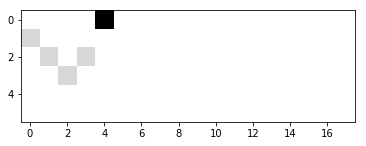

Target


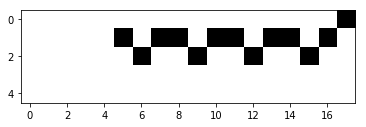

Predicted


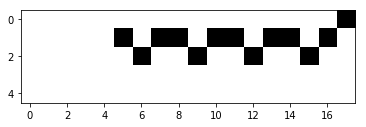

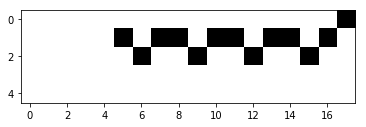

('Iteration', 57000, 'Train loss:', 1.8163706758229789e-05)
Test loss:  1.9129602166e-05
Input


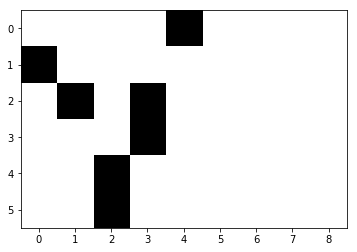

Target


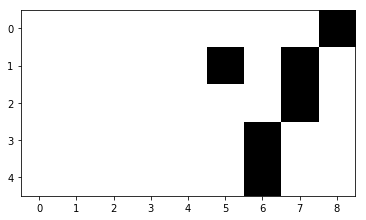

Predicted


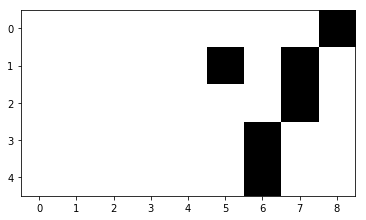

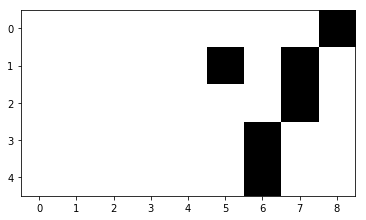

('Iteration', 58000, 'Train loss:', 4.2907162904402025e-05)
Test loss:  1.72035557126e-05
Input


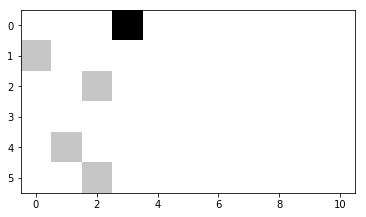

Target


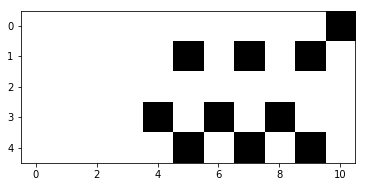

Predicted


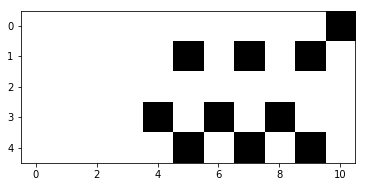

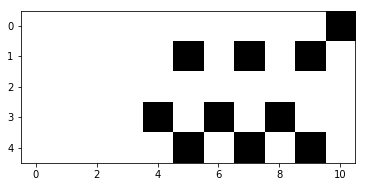

('Iteration', 59000, 'Train loss:', 3.2180425525604852e-06)
Test loss:  8.5224691314e-06
Input


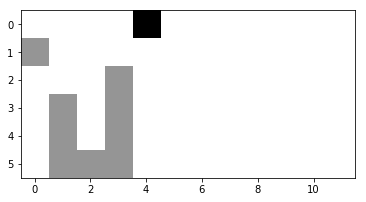

Target


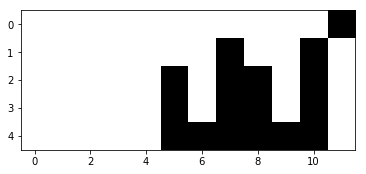

Predicted


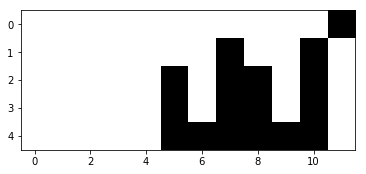

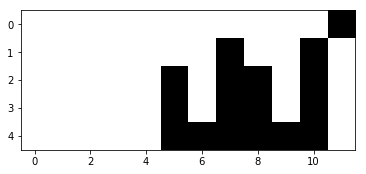

('Iteration', 60000, 'Train loss:', 1.3689062429529564e-05)
Test loss:  2.17896192514e-06
Input


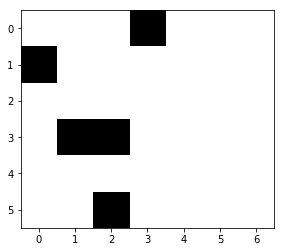

Target


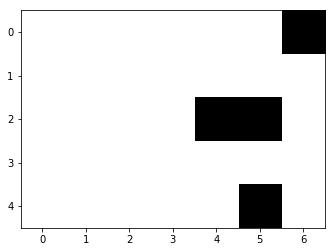

Predicted


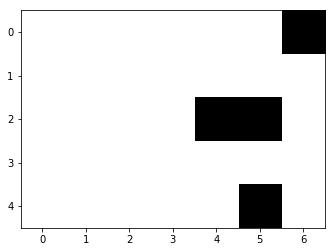

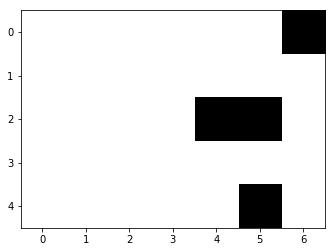

('Iteration', 61000, 'Train loss:', 3.0890899103100413e-05)
Test loss:  6.11658805415e-06
Input


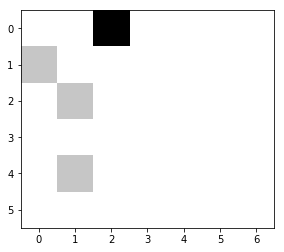

Target


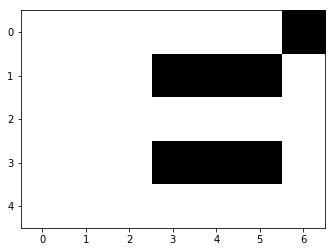

Predicted


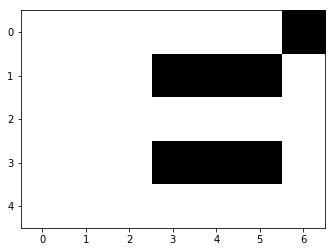

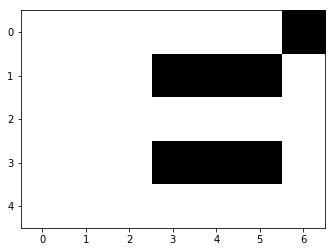

('Iteration', 62000, 'Train loss:', 0.00018327803530347614)
Test loss:  0.0463305652361
Input


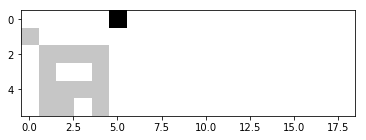

Target


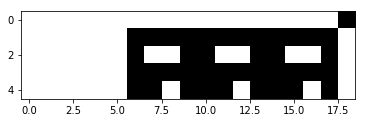

Predicted


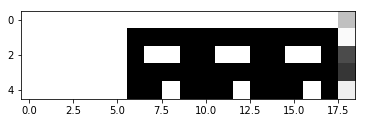

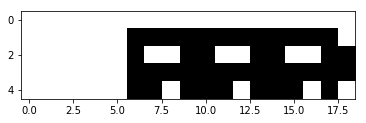

('Iteration', 63000, 'Train loss:', 1.4231746456557918e-06)
Test loss:  5.16765372461e-06
Input


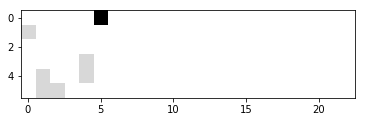

Target


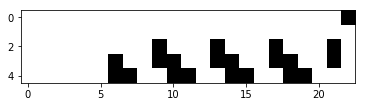

Predicted


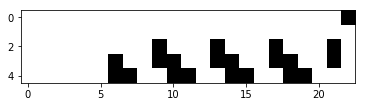

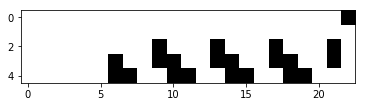

('Iteration', 64000, 'Train loss:', 1.3903877094248232e-05)
Test loss:  1.88771736139e-06
Input


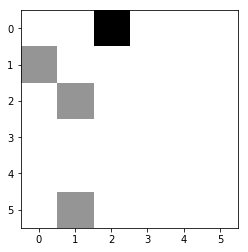

Target


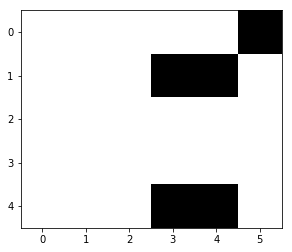

Predicted


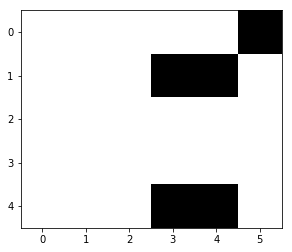

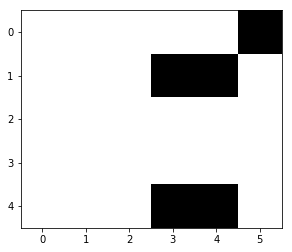

('Iteration', 65000, 'Train loss:', 8.9052812897201939e-07)
Test loss:  3.57987151582e-06
Input


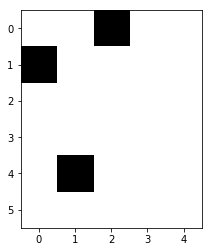

Target


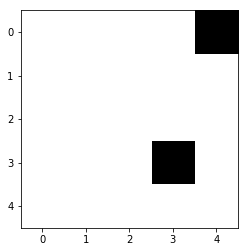

Predicted


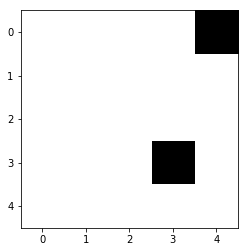

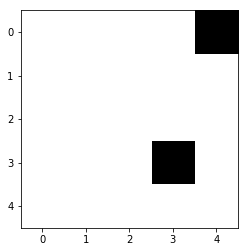

('Iteration', 66000, 'Train loss:', 2.0398349565178063e-07)
Test loss:  3.81794059093e-07
Input


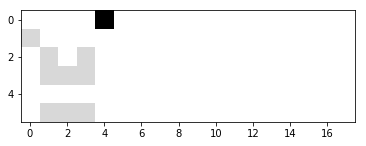

Target


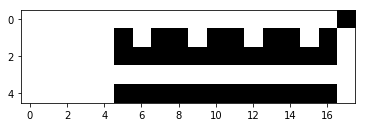

Predicted


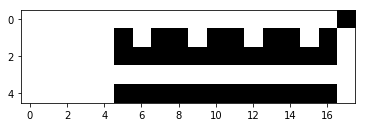

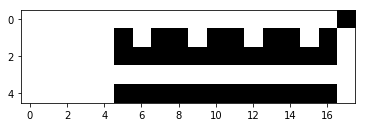

('Iteration', 67000, 'Train loss:', 1.1274500996494735e-06)
Test loss:  6.28881690514e-07
Input


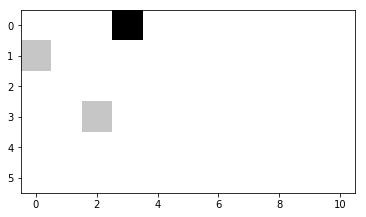

Target


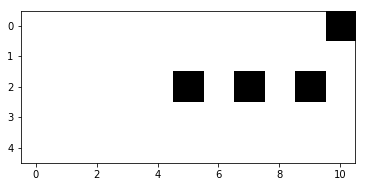

Predicted


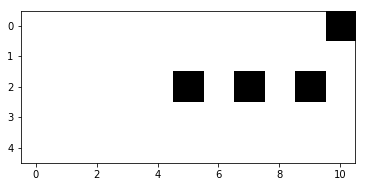

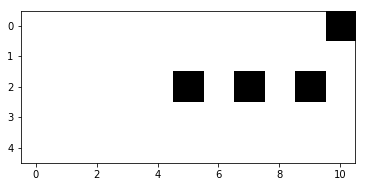

('Iteration', 68000, 'Train loss:', 1.1467849141866444e-06)
Test loss:  2.08957260957e-07
Input


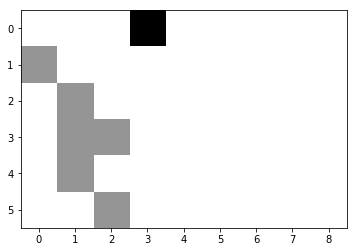

Target


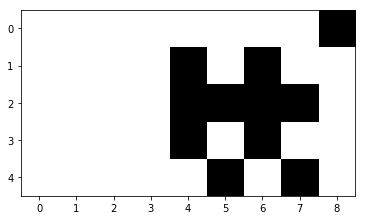

Predicted


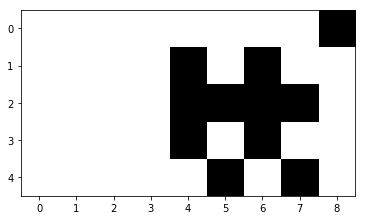

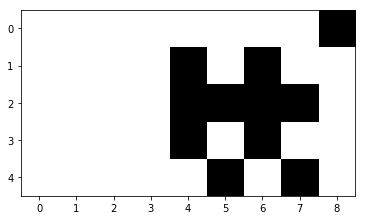

('Iteration', 69000, 'Train loss:', 3.5718718980825552e-07)
Test loss:  1.75228897645e-07
Input


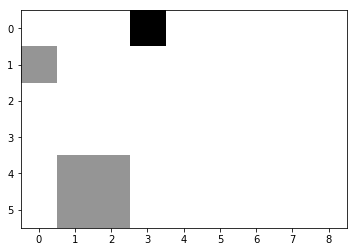

Target


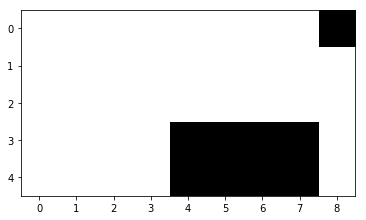

Predicted


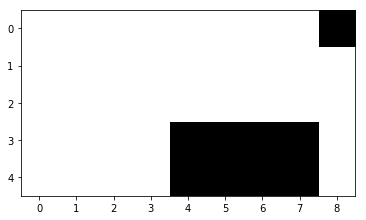

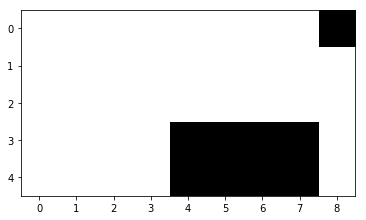

('Iteration', 70000, 'Train loss:', 4.2441429604284403e-07)
Test loss:  3.20550234516e-07
Input


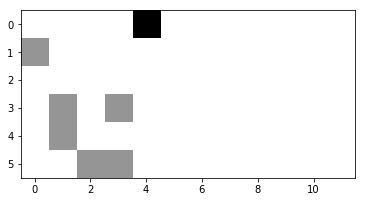

Target


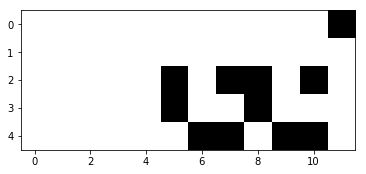

Predicted


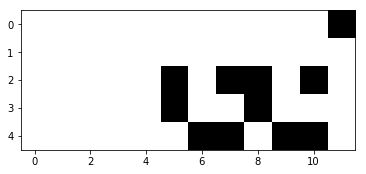

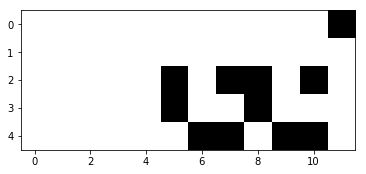

('Iteration', 71000, 'Train loss:', 4.4614169877814764e-07)
Test loss:  1.71707699328e-05
Input


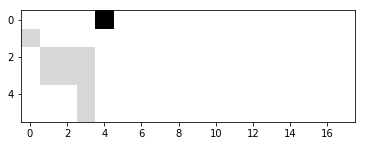

Target


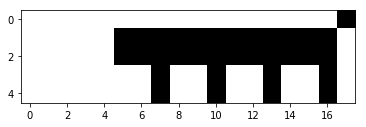

Predicted


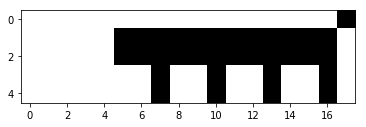

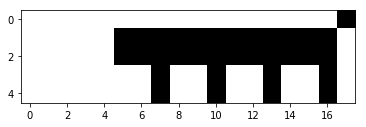

('Iteration', 72000, 'Train loss:', 2.4107705221655796e-06)
Test loss:  7.49349467016e-07
Input


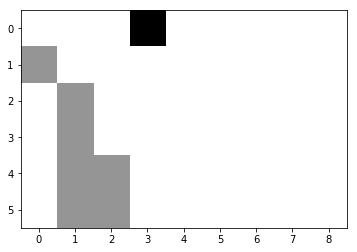

Target


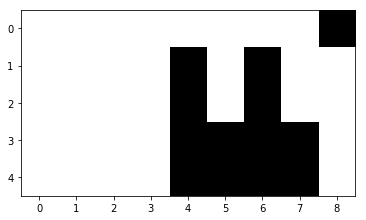

Predicted


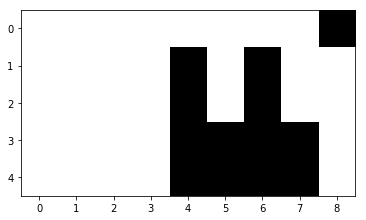

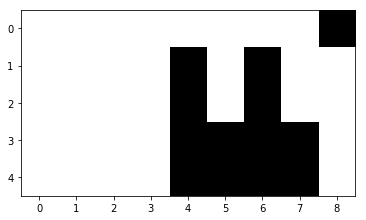

('Iteration', 73000, 'Train loss:', 4.1578362296979776e-08)
Test loss:  8.20807761596e-08
Input


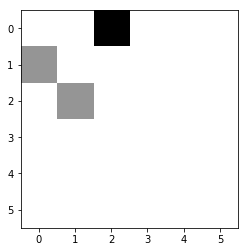

Target


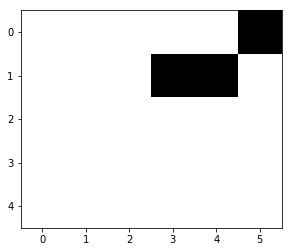

Predicted


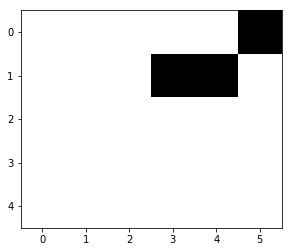

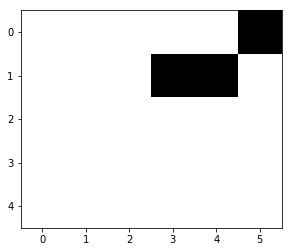

('Iteration', 74000, 'Train loss:', 9.2535560742161686e-08)
Test loss:  5.20561080787e-08
Input


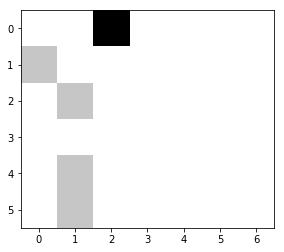

Target


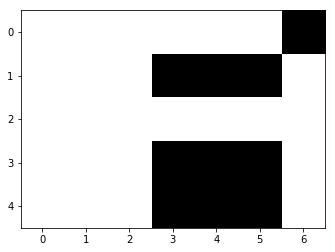

Predicted


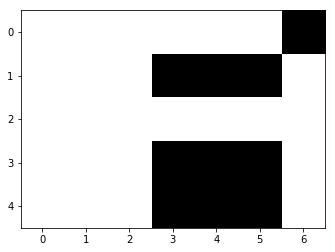

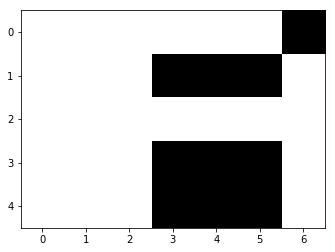

('Iteration', 75000, 'Train loss:', 6.3076671866807891e-06)
Test loss:  9.39629410286e-08
Input


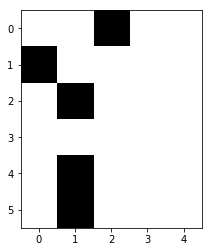

Target


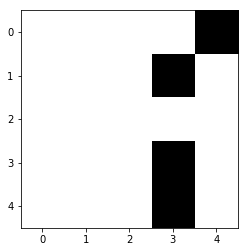

Predicted


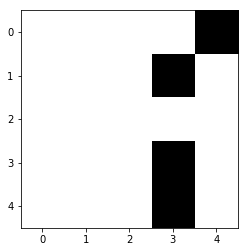

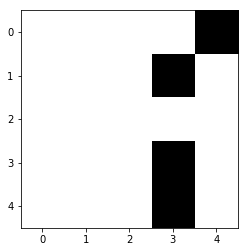

('Iteration', 76000, 'Train loss:', 0.28703794671600691)
Test loss:  5.71871338676e-08
Input


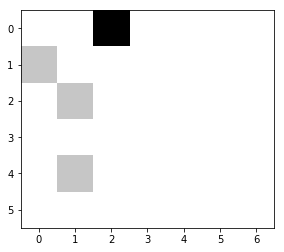

Target


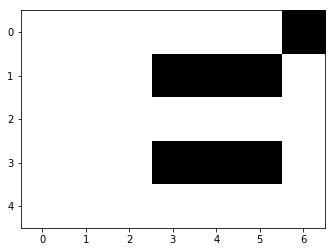

Predicted


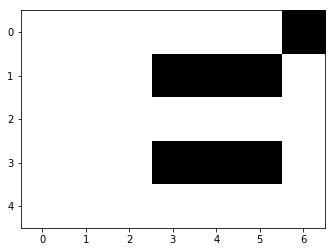

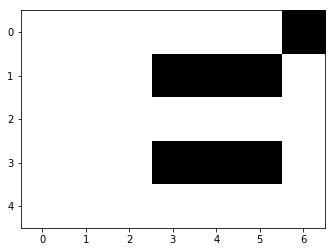

('Iteration', 77000, 'Train loss:', 4.5409448023825876e-08)
Test loss:  9.42990917641e-08
Input


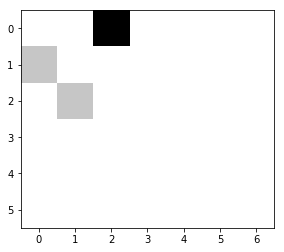

Target


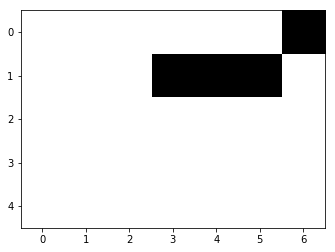

Predicted


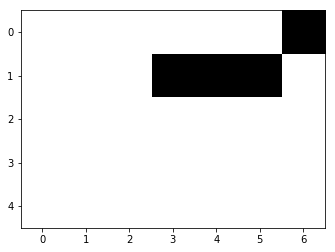

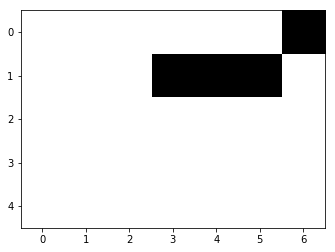

('Iteration', 78000, 'Train loss:', 8.1472915463838379e-08)
Test loss:  8.59290570881e-08
Input


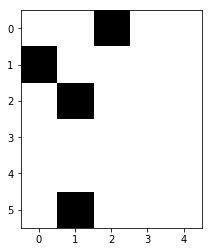

Target


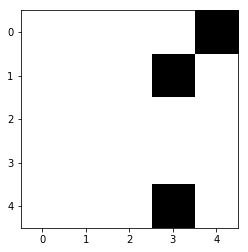

Predicted


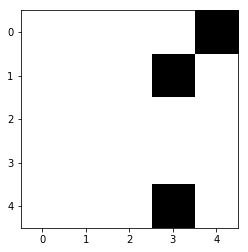

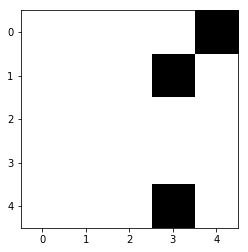

('Iteration', 79000, 'Train loss:', 2.4492383436401897e-06)
Test loss:  6.34184548876e-08
Input


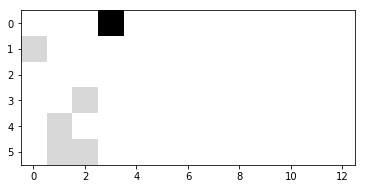

Target


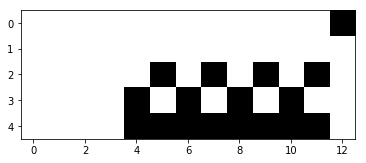

Predicted


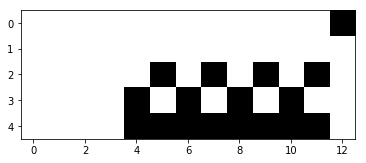

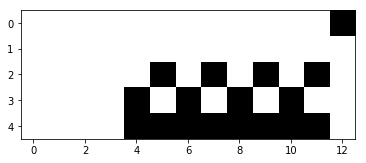

('Iteration', 80000, 'Train loss:', 9.4090995911106689e-08)
Test loss:  7.52564954537e-08
Input


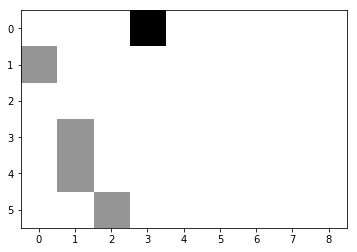

Target


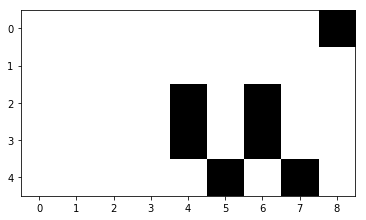

Predicted


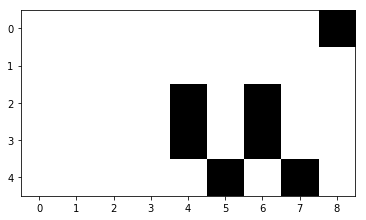

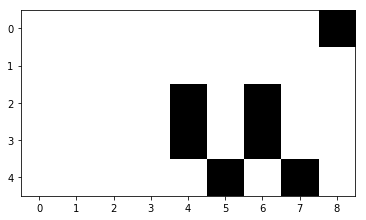

('Iteration', 81000, 'Train loss:', 2.1791301653117774e-08)
Test loss:  1.00274690781e-08
Input


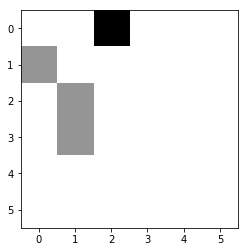

Target


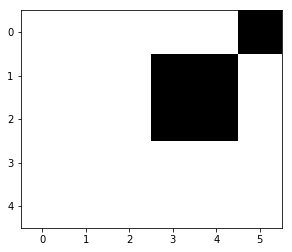

Predicted


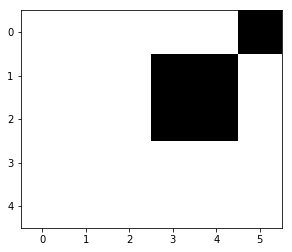

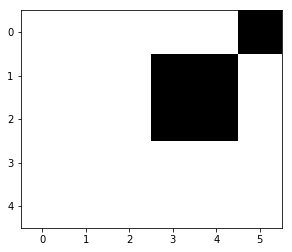

('Iteration', 82000, 'Train loss:', 1.6489251493082889e-08)
Test loss:  3.17399630076e-09
Input


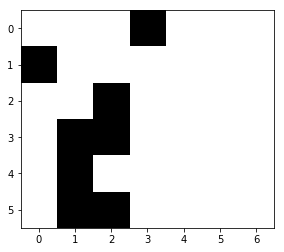

Target


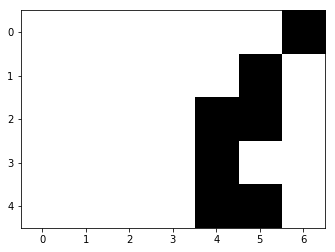

Predicted


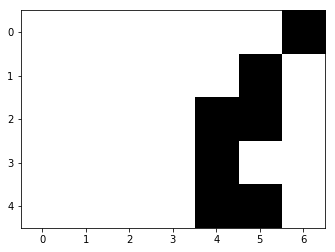

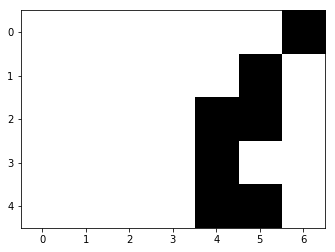

('Iteration', 83000, 'Train loss:', 2.959504571504219e-07)
Test loss:  4.30195807128e-07
Input


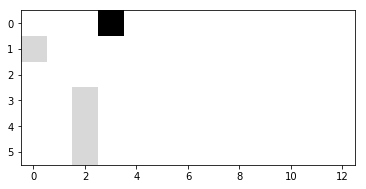

Target


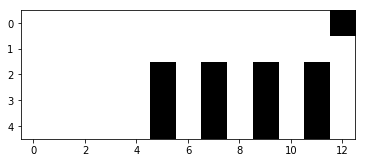

Predicted


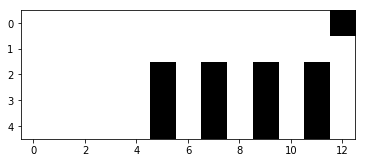

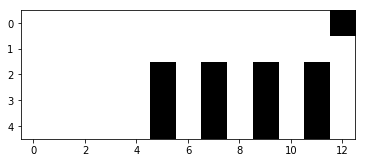

('Iteration', 84000, 'Train loss:', 1.4178786761795958e-07)
Test loss:  2.62759835074e-07
Input


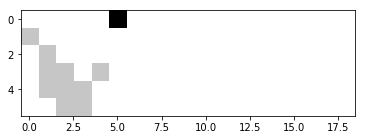

Target


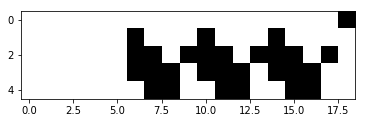

Predicted


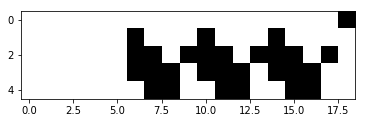

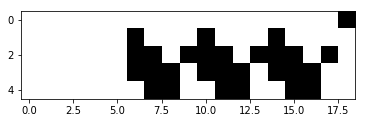

('Iteration', 85000, 'Train loss:', 3.979299721296463e-08)
Test loss:  3.09432288894e-09
Input


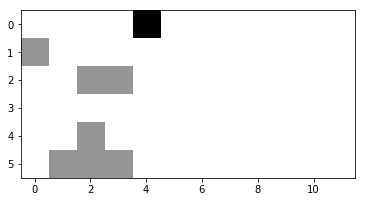

Target


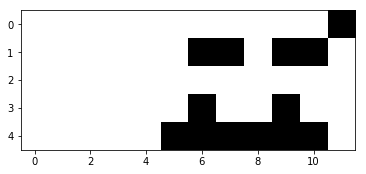

Predicted


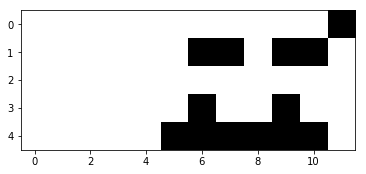

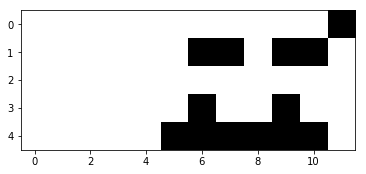

('Iteration', 86000, 'Train loss:', 3.8499454726656203e-09)
Test loss:  1.33483485468e-08
Input


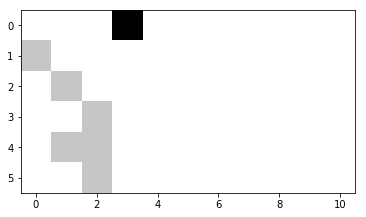

Target


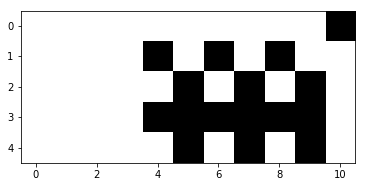

Predicted


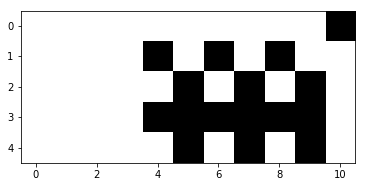

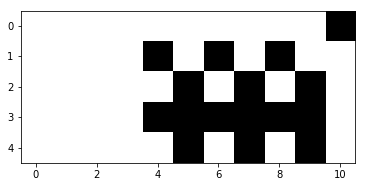

('Iteration', 87000, 'Train loss:', 4.9264601832377954e-09)
Test loss:  3.31040546775e-09
Input


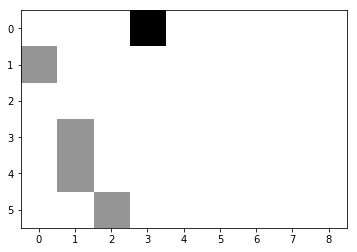

Target


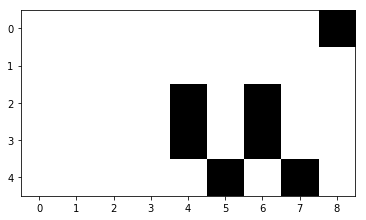

Predicted


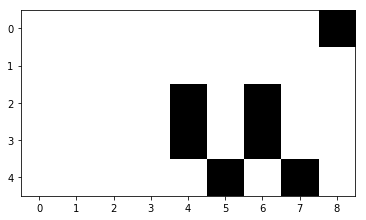

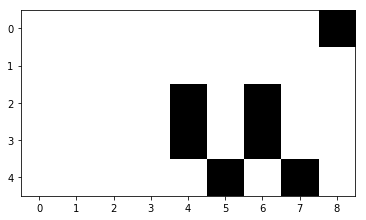

('Iteration', 88000, 'Train loss:', 4.6204507160372988e-07)
Test loss:  1.26668885142e-07
Input


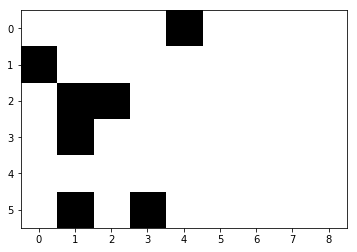

Target


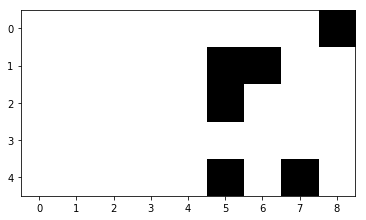

Predicted


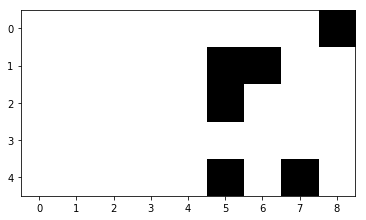

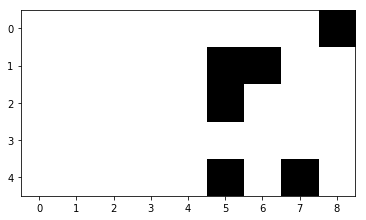

('Iteration', 89000, 'Train loss:', 4.4794890208026927e-09)
Test loss:  1.79373856522e-08
Input


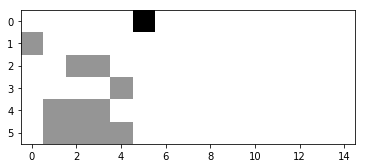

Target


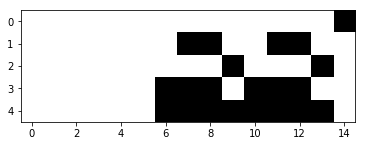

Predicted


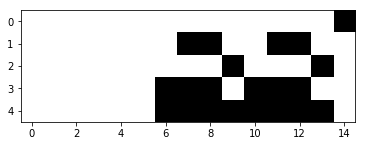

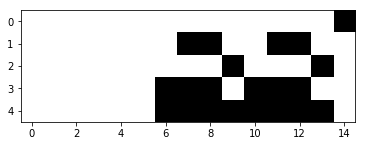

('Iteration', 90000, 'Train loss:', 1.7754140650691375e-07)
Test loss:  3.2805270203e-08
Input


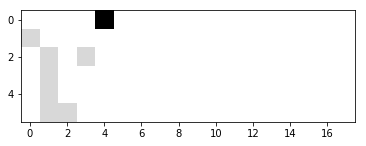

Target


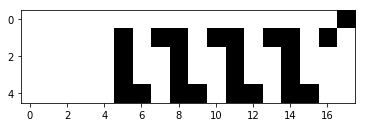

Predicted


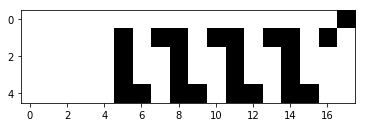

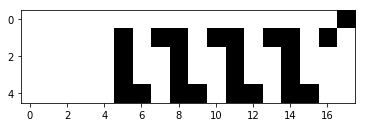

In [ ]:
## Testing recurrent DNC

def loss_fn(pred, target, mask):
    pred = sigmoid(pred)
    one = np.ones_like(pred)
    epsilon = 1.e-20 # to prevent log(0)
    a = target * np.log(pred + epsilon)
    b = (one - target) * np.log(one - pred + epsilon)
    return np.mean(- (a + b) * mask)

seq_len, seq_wid = 4, 4

# dnc = DNCFF(input_size=seq_wid+2, output_size=seq_wid+1, hidden_size=32, R=2, N=64, W=4)
dnc = DNC(input_size=seq_wid+2, output_size=seq_wid+1, hidden_size=32, R=2, N=64, W=8)
dnc_params = dnc._init_params()

def print_training_prediction(params, iters):
    
    inputs, targets, mask = repeat_copy(seq_len, seq_wid)
    result = []
    dnc = DNC(input_size=seq_wid+2, output_size=seq_wid+1, hidden_size=32, R=2, N=64, W=8)
    for t in range(inputs.shape[0]):
        out = dnc.step_forward(params, inputs[np.newaxis, t])
        result.append(out)
    result = np.concatenate(result, axis=0)
    loss = loss_fn(result, targets, mask)
    print "Test loss: ", loss
    print "Input"
    display(inputs.T)
    print "Target"
    display(targets.T)
    print "Predicted"
    display((sigmoid(result)).T)
    display(np.around((sigmoid(result) * mask), decimals=0).astype('int').T)
    
    # Saving Model Check Points
    save_pickle(params, './ckpt/repeated_copy/Iter_%d_Loss_%.6f.pkl' % (iters, loss))

    
def training_loss(params, iters):
    inputs, targets, mask = repeat_copy(seq_len, seq_wid)
    result = []
    dnc = DNC(input_size=seq_wid+2, output_size=seq_wid+1, hidden_size=32, R=2, N=64, W=8)
    for t in range(inputs.shape[0]):
        out = dnc.step_forward(params, inputs[np.newaxis, t])
        result.append(out)
    result = np.concatenate(result, axis=0)
    return loss_fn(result, targets, mask)

def callback(weights, iters, gradient):
    if iters % 1000 == 0:
        print("Iteration", iters, "Train loss:", training_loss(weights, 0))
        print_training_prediction(weights, iters)

# Build gradient of loss function using autograd.
training_loss_grad = grad(training_loss)

print("Training DNC...")
# trained_params = adam(training_loss_grad, dnc_params, step_size=0.001,
#                       num_iters=1000000, callback=callback)
trained_params = rmsprop(training_loss_grad, dnc_params, step_size=0.001,
                      num_iters=1000000, callback=callback)